# Decision Tree Classifier

In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix


In [4]:
# Load dataset

dataset= pd.read_csv('dataset.csv')

# Replace 'Unknown' with NaN in Target
dataset['Genetic Disorder'].replace('Unknown', np.nan, inplace=True)
dataset['Disorder Subclass'].replace('Unknown', np.nan, inplace=True)

dataset.dropna(inplace=True)

# Alocate features and labels

X = dataset.iloc[:, :-2]  # Features
y = dataset.iloc[:, -2:]  # Labels (last two columns)

# Perform one-hot encoding on the categorical features
X = pd.get_dummies(X, drop_first=True)
# drop_first is used to drop one of the columns for each categorical feature to avoid multicollinearity.

# Check if the target variable has more than 2 classes
if y.nunique().any() > 2:
    y = pd.get_dummies(y, drop_first=True)


# Split the data into validation, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,  random_state=1) # training as 75% 
    

In [7]:
# Select and train model of classifier

# Best Hyperparameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 10, 'estimator__splitter': 'random'}
# Best Mean Accuracy: 0.2690801625415589

dt = MultiOutputClassifier(tree.DecisionTreeClassifier(criterion= 'gini', max_depth= '10', max_features= None, min_samples_leaf= '1', min_samples_split= 10, splitter = 'random', random_state = 1))

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test) 


InvalidParameterError: The 'max_depth' parameter of DecisionTreeClassifier must be an int in the range [1, inf) or None. Got '10' instead.

In [9]:
# Separate the multi output targets
y_test_last1 = y_test.iloc[:, -1]
y_test_last2 = y_test.iloc[:, -2]

y_pred_last1 = y_pred[:, -1]
y_pred_last2 = y_pred[:, -2]

# Evaluate the model

balanced_acc_last1 = balanced_accuracy_score(y_test_last1, y_pred_last1)
balanced_acc_last2 = balanced_accuracy_score(y_test_last2, y_pred_last2)


# Use dataset without Unknown values

In [10]:
# Train models without unknown data

# Replace 'Unknown' with NaN
dataset.replace('Unknown', np.nan, inplace=True)

dataset.dropna(inplace=True)

In [11]:
# Alocate features and labels

X = dataset.iloc[:, :-2]  # Features
y = dataset.iloc[:, -2:]  # Labels (last two columns)

# Perform one-hot encoding on the categorical features
X = pd.get_dummies(X, drop_first=True)
# drop_first is used to drop one of the columns for each categorical feature to avoid multicollinearity.

# Check if the target variable has more than 2 classes
if y.nunique().any() > 2:
    y = pd.get_dummies(y, drop_first=True)

# split the data into validation, validation and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,  random_state=1) # training as 75%

In [12]:
# Select and train model of classifier

dt = MultiOutputClassifier(tree.DecisionTreeClassifier(splitter = 'random', random_state = 1))
# evaluate the change of the criterion from gini to entropy?

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test) 


In [13]:
# Separate the multi output targets
y_test_last1_new = y_test.iloc[:, -1]
y_test_last2_new = y_test.iloc[:, -2]

y_pred_last1_new = y_pred[:, -1]
y_pred_last2_new = y_pred[:, -2]

# Evaluate the model

balanced_acc_last1_new = balanced_accuracy_score(y_test_last2_new, y_pred_last2_new)
balanced_acc_last2_new = balanced_accuracy_score(y_test_last2_new, y_pred_last2_new)


In [14]:
# Metrics and information for each output column
'''
metrics_dict = {
    'Model': 'Decision Tree - W/ Unknowns',

    # Metrics for the original dataset
    'Scenario': 'Original',
    'Balanced Accuracy (Last Column)': balanced_acc_last1,
    'Balanced Accuracy (Second to Last Column)': balanced_acc_last2,
    'Classification Report (Last Column)': classification_report(y_test_last1, y_pred_last1),
    'Classification Report (Second to Last Column)': classification_report(y_test_last2, y_pred_last2),

    # Metrics for the dataset without samples with unknown values
    'Scenario': 'Decision Tree - Removed Unknowns',
    'Balanced Accuracy (Last Column)': balanced_acc_last1_new,
    'Balanced Accuracy (Second to Last Column)': balanced_acc_last2_new,
    'Classification Report (Last Column)': classification_report(y_test_last1_new, y_pred_last1_new),
    'Classification Report (Second to Last Column)': classification_report(y_test_last2_new, y_pred_last2_new),
}

# Convert the dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics_dict.items(), columns=['Metric', 'Value'])

# Save the DataFrame to an Excel file
file_path = 'metrics_report.csv'
metrics_df.to_csv(file_path, index=False)
'''

"\nmetrics_dict = {\n    'Model': 'Decision Tree - W/ Unknowns',\n\n    # Metrics for the original dataset\n    'Scenario': 'Original',\n    'Balanced Accuracy (Last Column)': balanced_acc_last1,\n    'Balanced Accuracy (Second to Last Column)': balanced_acc_last2,\n    'Classification Report (Last Column)': classification_report(y_test_last1, y_pred_last1),\n    'Classification Report (Second to Last Column)': classification_report(y_test_last2, y_pred_last2),\n\n    # Metrics for the dataset without samples with unknown values\n    'Scenario': 'Decision Tree - Removed Unknowns',\n    'Balanced Accuracy (Last Column)': balanced_acc_last1_new,\n    'Balanced Accuracy (Second to Last Column)': balanced_acc_last2_new,\n    'Classification Report (Last Column)': classification_report(y_test_last1_new, y_pred_last1_new),\n    'Classification Report (Second to Last Column)': classification_report(y_test_last2_new, y_pred_last2_new),\n}\n\n# Convert the dictionary to a Pandas DataFrame\nmetr

In [15]:
# Metrics and information for each output column
print('\nClassification Report (Last Column):')
print(classification_report(y_test_last1, y_pred_last1))
print("balanced accuracy:", balanced_acc_last1)

print('\nClassification Report (Second to Last Column):')
print(classification_report(y_test_last2, y_pred_last2))
print("balanced accuracy:", balanced_acc_last2)

print('\n-------------------------REMOVING UNKNOWNS ---------------------------')

print('\nClassification Report (Last Column):')
print(classification_report(y_test_last1_new, y_pred_last1_new))
print("balanced accuracy:", balanced_acc_last1_new)

print('\nClassification Report (Second to Last Column):')
print(classification_report(y_test_last2_new, y_pred_last2_new))
print("balanced accuracy:", balanced_acc_last2_new)


Classification Report (Last Column):
                                     precision    recall  f1-score   support

                        Alzheimer's       0.11      0.12      0.12        32
                             Cancer       0.07      0.05      0.05        22
                    Cystic fibrosis       0.36      0.39      0.38       745
                           Diabetes       0.28      0.26      0.27       417
                    Hemochromatosis       0.29      0.27      0.28       315
Leber's hereditary optic neuropathy       0.24      0.23      0.23       141
                     Leigh syndrome       0.38      0.37      0.38      1186
             Mitochondrial myopathy       0.31      0.33      0.32      1016
                          Tay-Sachs       0.27      0.25      0.26       638

                           accuracy                           0.32      4512
                          macro avg       0.26      0.25      0.25      4512
                       weighted avg 

c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Tuning Hyperparameters

Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__splitter': 'best'}, Mean Accuracy: 0.20480236424085704
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__splitter': 'random'}, Mean Accuracy: 0.206575544883635
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__splitter': 'best'}, Mean Accuracy: 0.20243812338381972
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__splitter': 'random'}, Mean Accuracy: 0.20694495751754713
Parameters: {'estimato

ValueError: x and y must have same first dimension, but have shapes (1,) and (432,)

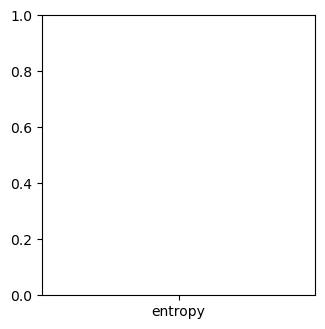

In [5]:

from sklearn.model_selection import ParameterGrid


# Define the hyperparameter grid for Decision Tree
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__splitter': ['best', 'random'],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': [None, 'sqrt', 'log2']
}

# Create a Decision Tree classifier wrapped with MultiOutputClassifier
dt = MultiOutputClassifier(tree.DecisionTreeClassifier())

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Lists to store results
all_mean_scores = []

for params in grid:
    dt.set_params(**params)

    # Perform cross-validation
    scores = cross_val_score(dt, X_train, y_train, cv=5)
  
    # Calculate mean accuracy and store the results
    mean_accuracy = scores.mean()
    all_mean_scores.append((params, mean_accuracy))
    
    print(f'Parameters: {params}, Mean Accuracy: {mean_accuracy}')

# Find the best hyperparameters based on the highest mean accuracy
best_params, best_mean_accuracy = max(all_mean_scores, key=lambda x: x[1])

print("Best Hyperparameters:", best_params)
print("Best Mean Accuracy:", best_mean_accuracy)



# Identifying Unnecessary Features

In [17]:
import seaborn as sns

num_outputs = len(y_test[0])  # Assuming y_test is a list of arrays or a DataFrame with multiple columns

# Create an empty confusion matrix to aggregate results for each output
aggregate_cm = np.zeros((num_outputs, num_outputs), dtype=int)

# Iterate through each output and calculate confusion matrix
for i in range(num_outputs):
    cm_i = confusion_matrix(y_test[:, i], y_pred[:, i])
    aggregate_cm += cm_i

# Create a heatmap for the aggregated confusion matrix
sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})
plt.show()

KeyError: 0